In [1]:
import os
import sys
from chordUtils import json2lab, MBIDAwareKFold
from subprocess import call
import json
import argparse
import chordUtils
import essentia.standard
import vamp
import numpy as np
import re
import pandas as pd
import math
import time

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from scipy.misc import logsumexp


sns.set(style="white", context="talk")
degrees=['I', 'IIb', 'II', 'IIIb', 'III', 'IV', 'Vb', 'V', 'VIb', 'VI', 'VIIb', 'VII']
allkinds=np.array(['maj', 'min', 'dom', 'hdim7', 'dim'])

def normalize(chromas, norm='l1'):
    data = chromas
    data=preprocessing.normalize(chromas, norm=norm)
    return data

def logNormalize(chromas):
    data = chromas
    data[data == 0] = np.exp(-10)
    data=np.log(preprocessing.normalize(chromas, norm='l1'))
    #data=preprocessing.normalize(chromas, norm='l1')

    # '/1000' is a hack in order to eliminate zero deviation.
    data[data < -10.0] = -10
    data[np.isnan(data)] = -10
    data[np.isinf(data)] = -10

    return data

def imputeZeros(data):
    data[data == 0] = 0.0001 
    return preprocessing.normalize(data, norm='l1')

def toLogRatio(chromaVector) :
    res = np.zeros(11)
    product = 1.0
    for i in range(11):
        product = product * chromaVector[i]
        ii = i + 1.0
        res[i] = np.sqrt(ii / (ii + 1)) * np.log( product ** (1.0/ii) / chromaVector[i + 1])
    return res

def normalizeTo11d(chromas) :
    c = imputeZeros(chromas)
    c = np.apply_along_axis(toLogRatio, 1, chromas)
    return c

def estimateBICs(data, min_components=1, max_components=40):
    res = np.zeros(max_components - min_components + 1)
    for i in range(min_components, max_components + 1):
        gm = GaussianMixture(
            n_components=i, covariance_type='full',
            max_iter=200,
            random_state = 8)
        gm.fit(data)
        curBic = gm.bic(data)
        res[i - 1] = curBic
        if (not gm.converged_):
            print i, curBic, gm.converged_
    return res

def findOptimalNComponentsByBIC(chromas, min_components=1, max_components=40):
    fig, ax = plt.subplots(nrows=3,ncols=2)
    ax = np.reshape(np.array(ax), (1, np.size(ax)))[0]
    res = np.zeros(5)
    for i in xrange(5):
        chordname = allkinds[i]
        samples = chromas[kinds ==chordname]
        bics = estimateBICs(samples,\
                           min_components=min_components,\
                           max_components=min(max_components, len(samples)))
        ax[i].set_title(chordname)
        ax[i].plot(bics)
        minIndex = np.argmin(bics)
        print chordname, "BIC: ", bics[minIndex], " N: ", minIndex + 1
        res[i] = minIndex + 1
    plt.show()
    return res
    
def fitMixture(data, n_components=1):
    gm = GaussianMixture(
        n_components=n_components, covariance_type='full',
        max_iter=200,
        random_state = 8)
    gm.fit(data)
    return gm

In [2]:
def violinPlots12D(kinds, choromas) :
    dMaj = pd.DataFrame(data=choromas[kinds =='maj'], columns=degrees)
    sns.violinplot(data=dMaj, inner="point")
    plt.show()
    dMin = pd.DataFrame(data=choromas[kinds =='min'], columns=degrees)
    sns.violinplot(data=dMin, inner="point")
    plt.show()
    dDom = pd.DataFrame(data=choromas[kinds =='dom'], columns=degrees)
    sns.violinplot(data=dDom, inner="point")
    plt.show()
    dHdim = pd.DataFrame(data=choromas[kinds =='hdim7'], columns=degrees)
    sns.violinplot(data=dHdim, inner="point")
    plt.show()    
    dDim = pd.DataFrame(data=choromas[kinds =='dim'], columns=degrees)
    sns.violinplot(data=dDim, inner="point")
    plt.show()
    
def violinPlots11D(kinds, choromas) :
    dMaj = pd.DataFrame(data=choromas[kinds =='maj'])
    sns.violinplot(data=dMaj, inner="point")
    plt.show()
    dMin = pd.DataFrame(data=choromas[kinds =='min'])
    sns.violinplot(data=dMin, inner="point")
    plt.show()
    dDom = pd.DataFrame(data=choromas[kinds =='dom'])
    sns.violinplot(data=dDom, inner="point")
    plt.show()
    dHdim = pd.DataFrame(data=choromas[kinds =='hdim7'])
    sns.violinplot(data=dHdim, inner="point")
    plt.show()    
    dDim = pd.DataFrame(data=choromas[kinds =='dim'])
    sns.violinplot(data=dDim, inner="point")
    plt.show()

In [3]:
def removeUnclassified(list):
    (chromas, labels, kinds, mbids, start_times, durations) = list
    return (chromas[kinds != 'unclassified'],\
      labels[kinds != 'unclassified'],\
      kinds[kinds != 'unclassified'],\
      mbids[kinds != 'unclassified'],\
      start_times[kinds != 'unclassified'],\
      durations[kinds != 'unclassified'])

def kinds2nums(kinds):
    num = lambda x : np.where(allkinds == x)[0][0]
    return np.array([num(x) for x in kinds])

def nums2kinds(nums):
    return np.array([allkinds[x] for x in nums])

def fitConstModel(kinds, chromas, numbersOfComponents):
    dMaj = pd.DataFrame(data=chromas[kinds =='maj'])
    dMin = pd.DataFrame(data=chromas[kinds =='min'])
    dDom = pd.DataFrame(data=chromas[kinds =='dom'])
    dHdim = pd.DataFrame(data=chromas[kinds =='hdim7'])
    dDim = pd.DataFrame(data=chromas[kinds =='dim'])
    majGMM = fitMixture(dMaj.values, n_components=numbersOfComponents[0])
    minGMM = fitMixture(dMin.values, n_components=numbersOfComponents[1])
    domGMM = fitMixture(dDom.values, n_components=numbersOfComponents[2])
    hdimGMM = fitMixture(dHdim.values, n_components=numbersOfComponents[3])
    dimGMM = fitMixture(dDim.values, n_components=numbersOfComponents[4])
    return (majGMM, minGMM, domGMM, hdimGMM, dimGMM)

def chordScore(model, kinds, chroma):
    (majGMM, minGMM, domGMM, hdimGMM, dimGMM) = model
    return np.array([\
              majGMM.score_samples(chroma),\
              minGMM.score_samples(chroma),\
              domGMM.score_samples(chroma),\
              hdimGMM.score_samples(chroma),\
              dimGMM.score_samples(chroma)])
    
def score(model, kinds, chromas, debug=False):
    scores=chordScore(model, kinds, chromas)
    p = np.argmax(scores, axis=0)
    for i in xrange(5):
       chordname = allkinds[i] 
       pc = p[kinds == chordname]
       if (debug): 
           print chordname, 100.0 * sum(pc == i) / len(pc), "%"
    nums = kinds2nums(kinds)
    score = 100.0 * sum(p == nums) / len(nums)
    if (debug):
        print 'total: ', score, '%'
    return score

def trainTestModel(mbids, kinds, chromas, numbersOfComponents, debug=False, nfolds = 5):
    kf = MBIDAwareKFold(n_splits = nfolds, random_state = 8)
    testAcc = np.zeros(nfolds)
    trainAcc= np.zeros(nfolds)
    nfold = 0
    for train_index, test_index in kf.split(mbids):
        train_chromas = chromas[train_index]
        train_labels = labels[train_index]
        train_kinds = kinds[train_index]
        train_mbids = mbids[train_index]
        train_start_times = start_times[train_index]
        train_durations = durations[train_index]
        test_chromas = chromas[test_index]
        test_labels = labels[test_index]
        test_kinds = kinds[test_index]
        test_mbids = mbids[test_index]
        test_start_times = start_times[test_index]
        test_durations = durations[test_index]
        model = fitConstModel(train_kinds, train_chromas, numbersOfComponents)
        trainAcc[nfold] = score(model, train_kinds, train_chromas, debug)
        testAcc[nfold] = score(model, test_kinds, test_chromas, debug)
        if (debug):
            print trainAcc[nfold], testAcc[nfold]
        nfold +=1
    return (np.average(trainAcc), np.average(testAcc))

def trainTestSymmetricalModels(mbids, kinds, chromas, n_components=np.arange(1,6), debug=False):
    testAcc = np.zeros(len(n_components))
    trainAcc= np.zeros(len(n_components))
    i = 0
    for c in n_components:
        ncomp = np.ones(5, dtype=int) * int(c)
        (train, test) = trainTestModel(mbids, kinds, chromas, ncomp, nfolds=5, debug=debug)
        trainAcc[i] = train
        testAcc[i] = test
        i = i + 1
    return trainAcc, testAcc

In [4]:
symcomponents = np.array([1,2,5,10,15,20,25,30,35,40,45,50,60])
chromaFile = '../chroma130.npz'

# No normalization

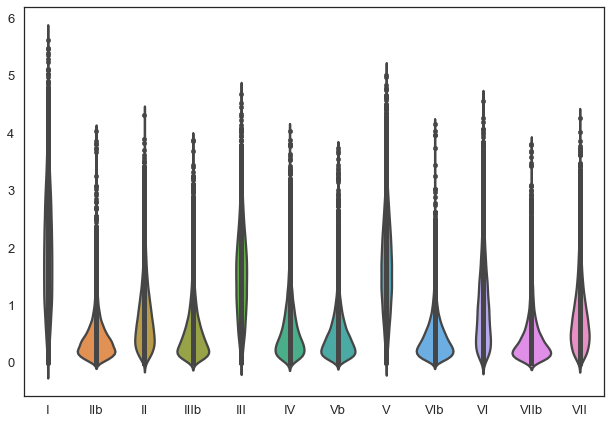

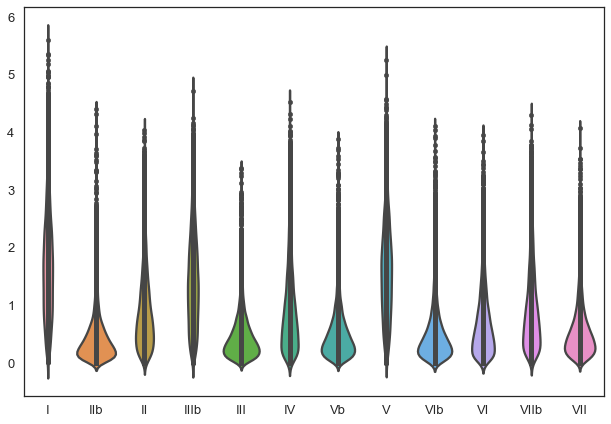

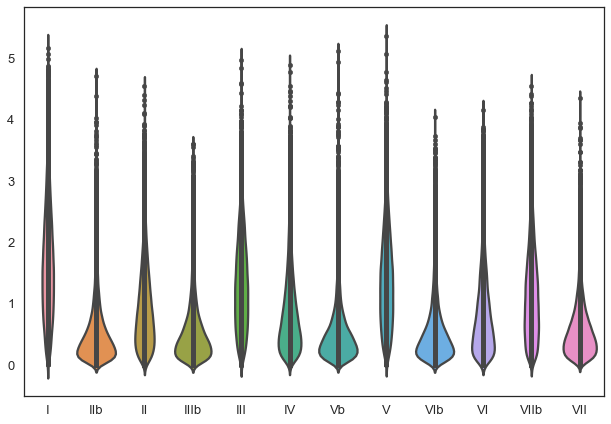

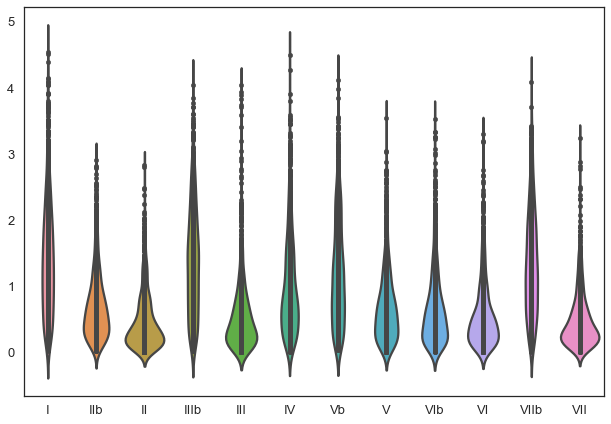

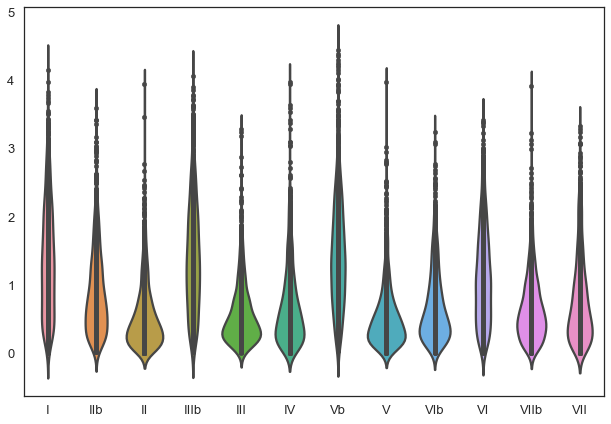

maj 75.1481888035 %
min 63.7423653526 %
dom 47.0460133474 %
hdim7 59.1772151899 %
dim 71.3483146067 %
total:  59.5418496533 %
maj BIC:  260459.309598  N:  23
min BIC:  202369.318955  N:  16
dom BIC:  466062.8539  N:  23
hdim7 BIC:  24467.3440863  N:  4
dim BIC:  29878.5986626  N:  6


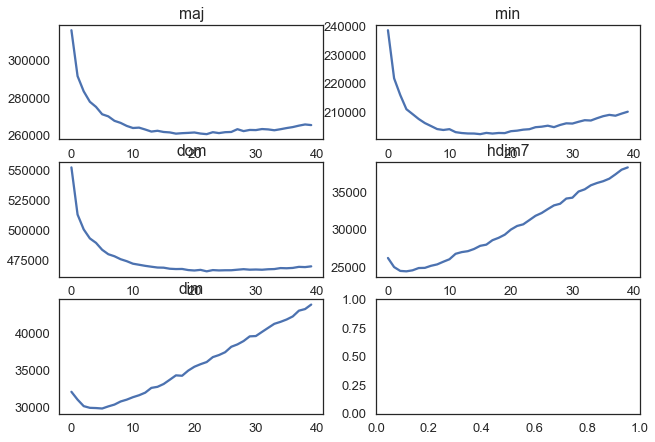

[ 23.  16.  23.   4.   6.]


In [5]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

violinPlots12D(kinds, chromas)
model = fitConstModel(kinds, chromas, [1,1,1,1,1])
score(model, kinds, chromas, debug=True)
n_components = findOptimalNComponentsByBIC(chromas)
print n_components

Time span:  1723.45562816
[ 59.84964415  61.50734992  63.78537077  66.41922986  68.17736867
  69.77296992  71.09209128  72.44670477  73.4727641   74.2687944
  75.54402011  76.29553082  77.93532984]
[ 58.73940137  59.82269098  60.60237159  61.4097828   61.98437534
  61.94176694  61.99543394  62.00014383  61.94440433  62.04535329
  61.85357989  61.96178168  61.72290829]


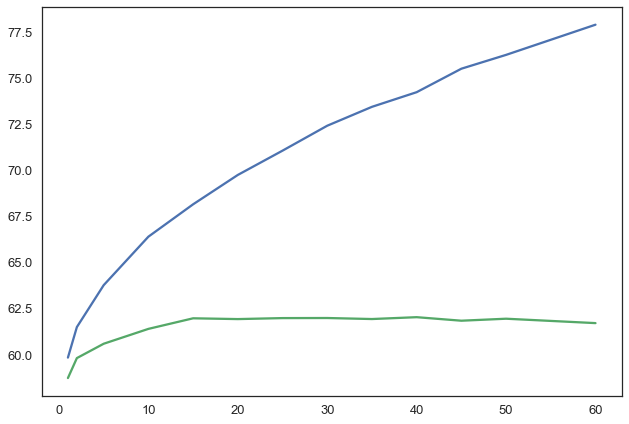

In [6]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

start = time.time()
rawTrains, rawTests = trainTestSymmetricalModels(mbids, kinds, chromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print rawTrains
print rawTests
plt.plot(symcomponents, rawTrains)
plt.plot(symcomponents, rawTests)
plt.show()

In [7]:
#np.array([1,2,5,10,15,20,25,30,35,40,45,50,60])

maj BIC:  471363.213994  N:  10
min BIC:  341798.288336  N:  9
dom BIC:  758067.899983  N:  17
hdim7 BIC:  36815.740366  N:  3
dim BIC:  44229.3787316  N:  3


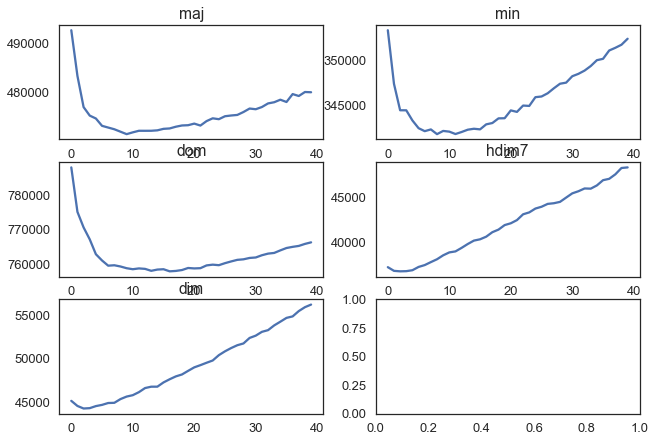

[ 10.   9.  17.   3.   3.]


In [8]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

sxChromas = normalizeTo11d(chromas)
violinPlots11D(kinds, sxChromas)
model = fitConstModel(kinds, sxChromas, [1,1,1,1,1])
score(model, kinds, sxChromas, debug=True)
n_components = findOptimalNComponentsByBIC(sxChromas)
print n_components

# Log-ratio transform

Time span:  1327.48607397
[ 64.05339193  63.67695962  64.97260352  67.01306691  68.6263615
  69.82606648  71.17165906  72.02270808  72.96240126  73.85356408
  74.69944659  75.51858611  76.93459405]
[ 62.69468396  61.62600795  61.88190676  61.99469978  62.08333133
  62.39159843  62.6059551   62.48797206  62.28426068  62.05877308
  62.17022325  61.98237613  61.56537392]


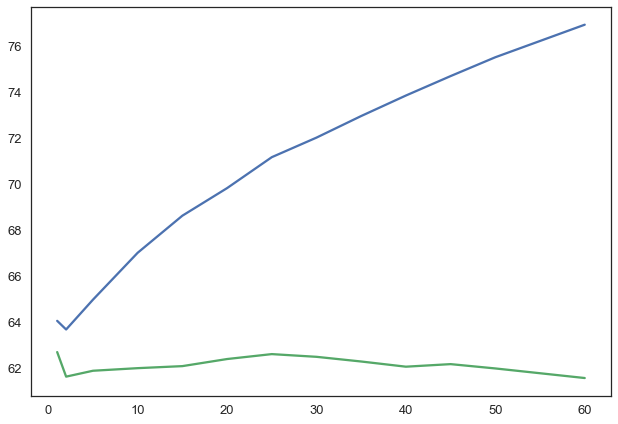

In [9]:
# Compositional data model
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

sxChromas = normalizeTo11d(chromas)
start = time.time()
sxTrains, sxTests = trainTestSymmetricalModels(mbids, kinds, sxChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print sxTrains
print sxTests
plt.plot(symcomponents, sxTrains)
plt.plot(symcomponents, sxTests)
plt.show()

# Just L1

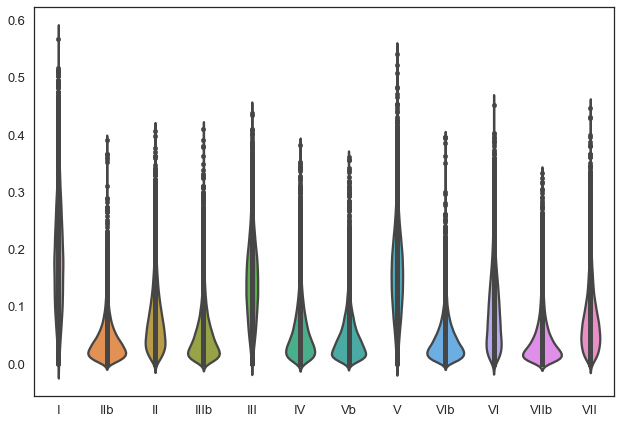

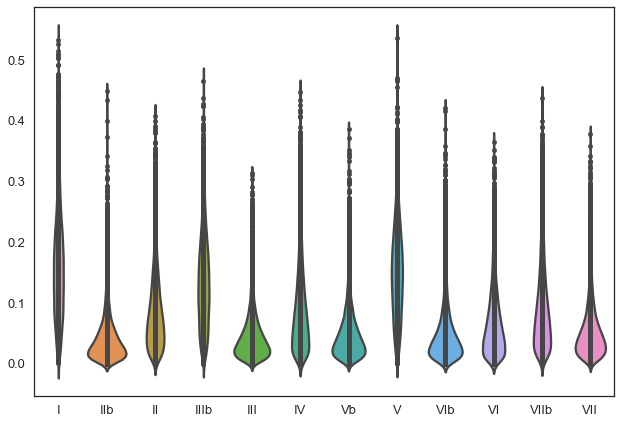

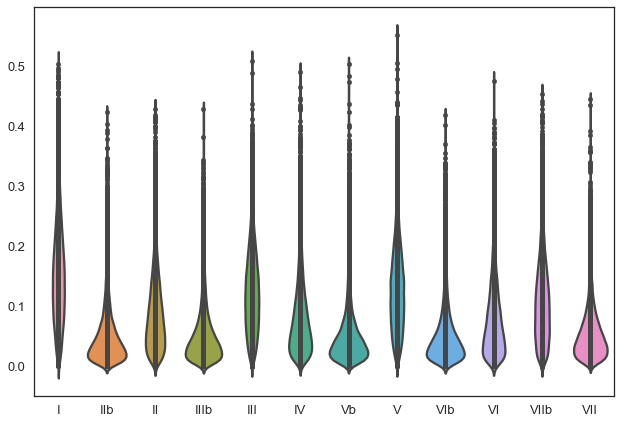

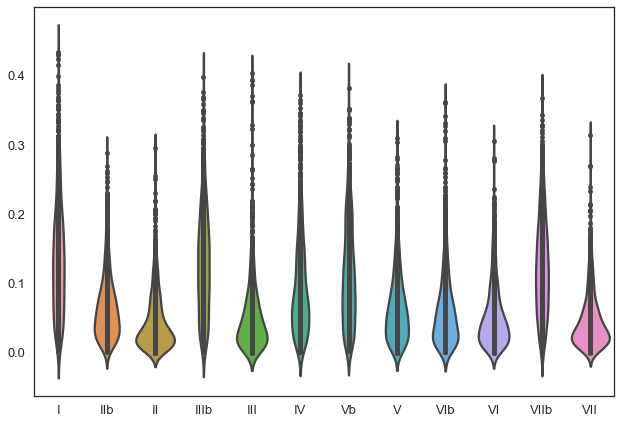

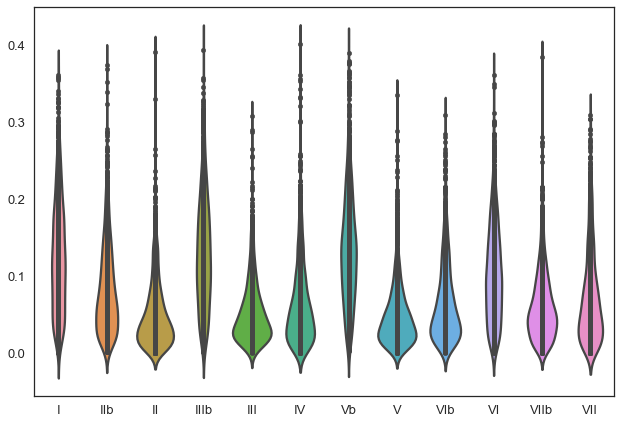

maj 63.6059275521 %
min 66.2806377409 %
dom 55.9079733052 %
hdim7 56.1708860759 %
dim 72.5343320849 %
total:  60.7017035857 %
Time span:  6176.04082489
[ 60.6575283   60.86359873  63.45645406  65.92794294  67.64357183
  68.98051224  70.18489473  71.34630965  72.25462262  73.164809
  74.10296854  75.00627468  76.59244841]
[ 59.68914722  59.44186021  60.7569566   61.35903108  61.69834867
  61.77521166  61.98554476  62.10762468  61.88390737  61.83540796
  62.08897022  61.92413492  61.89692725]


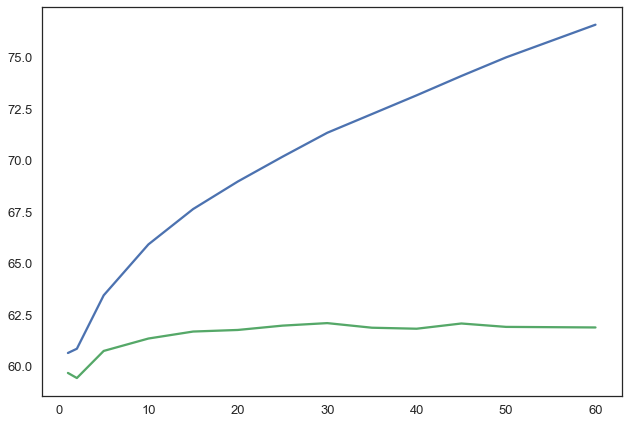

In [10]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

l1Chromas = normalize(chromas)
violinPlots12D(kinds, l1Chromas)
model = fitConstModel(kinds, l1Chromas, [1,1,1,1,1])
score(model, kinds, l1Chromas, debug=True)
#n_components = findOptimalNComponentsByBIC(l1Chromas)
#print n_components
start = time.time()
l1Trains, l1Tests = trainTestSymmetricalModels(mbids, kinds, l1Chromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print l1Trains
print l1Tests
plt.plot(symcomponents, l1Trains)
plt.plot(symcomponents, l1Tests)
plt.show()

# L1-log

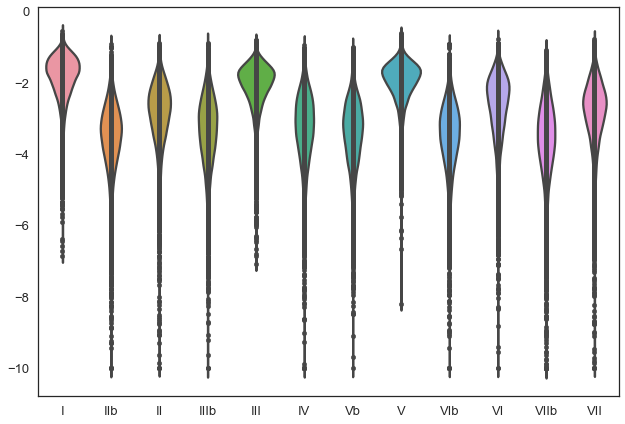

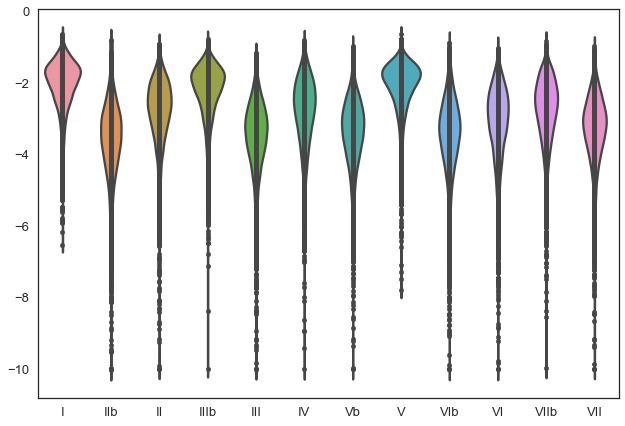

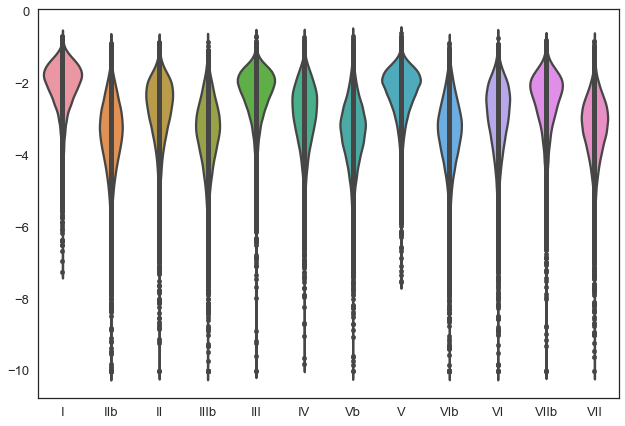

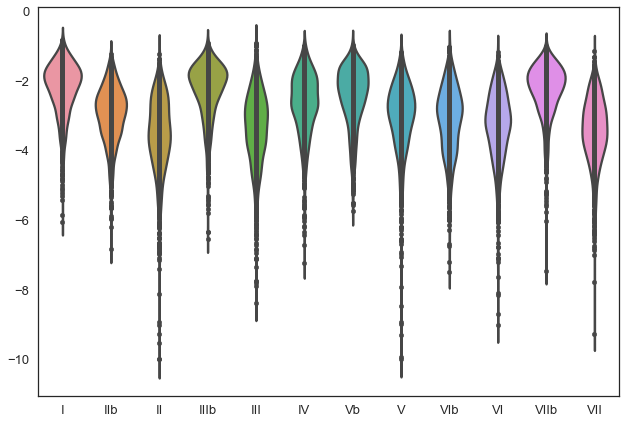

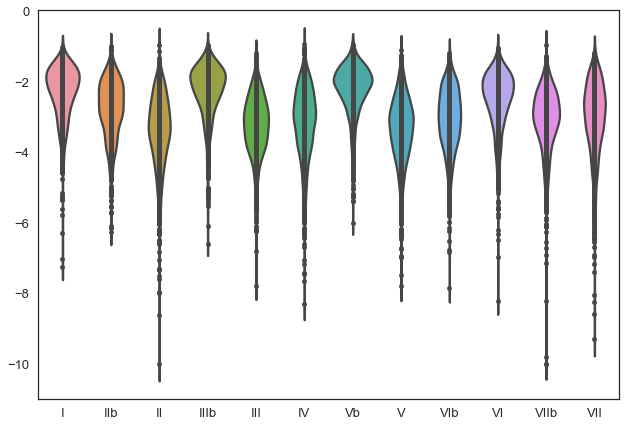

maj 72.2996706915 %
min 66.7803601174 %
dom 57.4464348437 %
hdim7 49.8417721519 %
dim 73.6579275905 %
total:  63.9560510271 %
Time span:  1685.62652111
[ 64.08203662  63.07584109  64.2133046   66.51845484  67.9350859
  69.20638087  70.19653307  71.26489118  72.10750168  72.979697
  73.80544805  74.52786425  76.05743995]
[ 62.49389706  61.29454378  61.38198127  61.99407959  62.0174131
  62.27824042  61.85332985  62.08021506  61.7588293   61.86974023
  61.90591159  61.88510588  61.57021986]


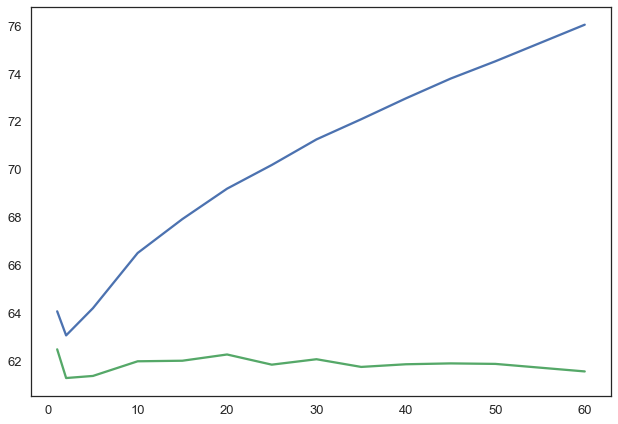

In [11]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

l1logChromas = logNormalize(chromas)
violinPlots12D(kinds, l1logChromas)
model = fitConstModel(kinds, l1logChromas, [1,1,1,1,1])
score(model, kinds, l1logChromas, debug=True)
#n_components = findOptimalNComponentsByBIC(l1logChromas)
#print n_components
start = time.time()
l1logTrains, l1logTests = trainTestSymmetricalModels(mbids, kinds, l1logChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print l1logTrains
print l1logTests
plt.plot(symcomponents, l1logTrains)
plt.plot(symcomponents, l1logTests)
plt.show()

# L2

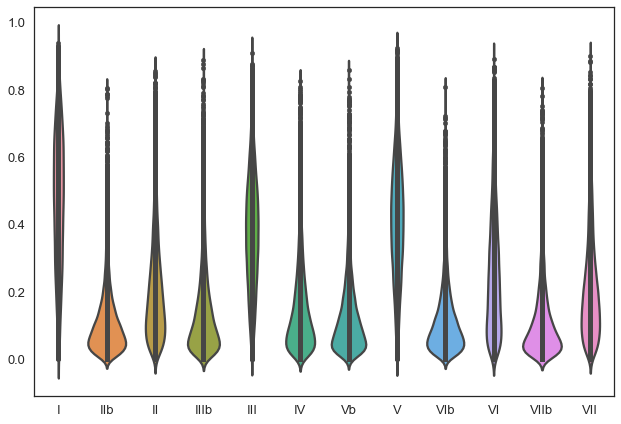

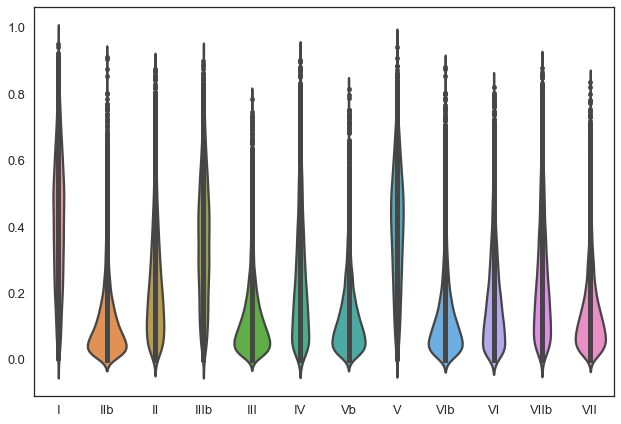

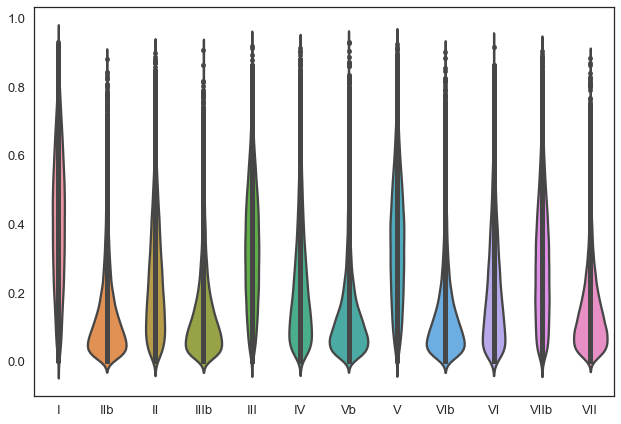

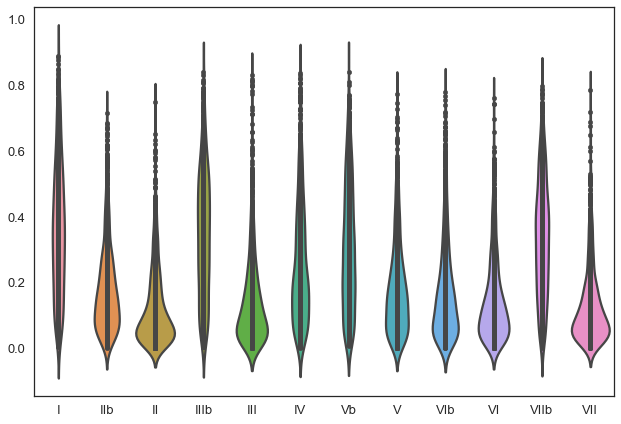

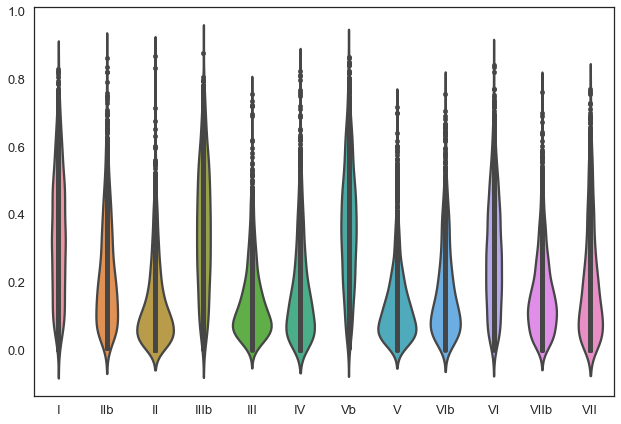

maj 75.1152579583 %
min 63.2426429761 %
dom 46.6736916052 %
hdim7 57.5158227848 %
dim 72.0973782772 %
total:  59.2458536428 %
Time span:  1406.92403793
[ 59.46588268  60.18771489  63.26500878  65.30778992  66.99018748
  68.13082175  69.23570061  70.35387438  71.38419018  72.34291882
  73.16494847  74.12165699  75.74511143]
[ 58.41378056  58.46522767  60.75067942  60.96878409  61.53176318
  61.53807728  61.31933906  61.44430237  61.50750343  61.41427762
  61.47892992  61.7410774   61.50975309]


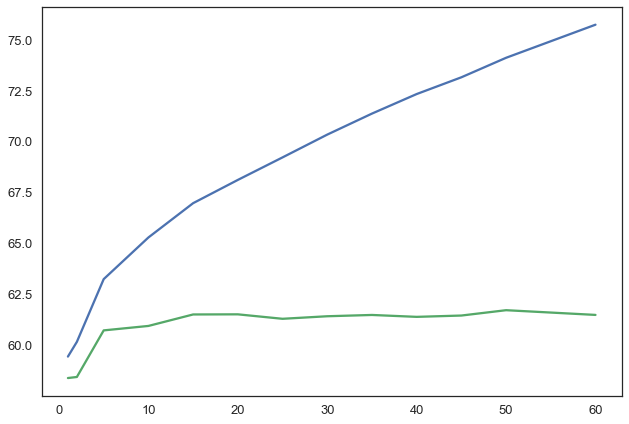

In [12]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

l2Chromas = normalize(chromas, norm='l2')
violinPlots12D(kinds, l2Chromas)
model = fitConstModel(kinds, l2Chromas, [1,1,1,1,1])
score(model, kinds, l2Chromas, debug=True)
#model = fitConstModel(kinds, l2Chromas, [1,7,2,1,1])
#score(model, kinds, l2Chromas)
#n_components = findOptimalNComponentsByBIC(l2Chromas)
#print n_components
start = time.time()
l2Trains, l2Tests = trainTestSymmetricalModels(mbids, kinds, l2Chromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print l2Trains
print l2Tests
plt.plot(symcomponents, l2Trains)
plt.plot(symcomponents, l2Tests)
plt.show()

# Lmax

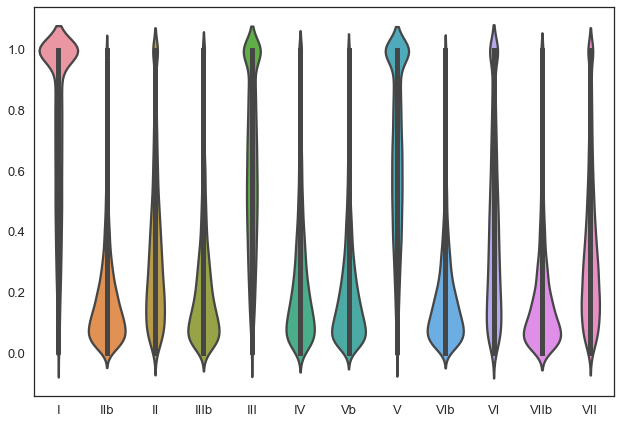

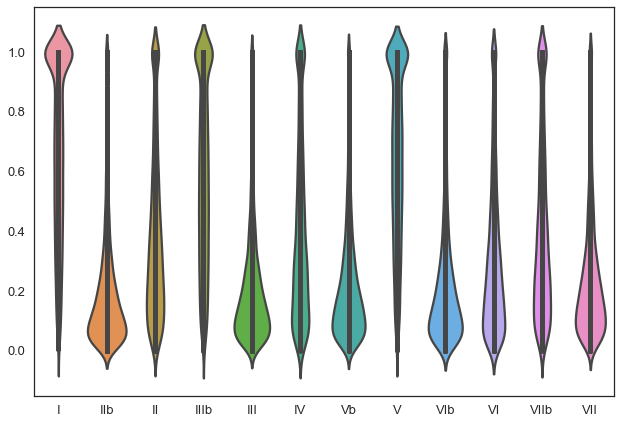

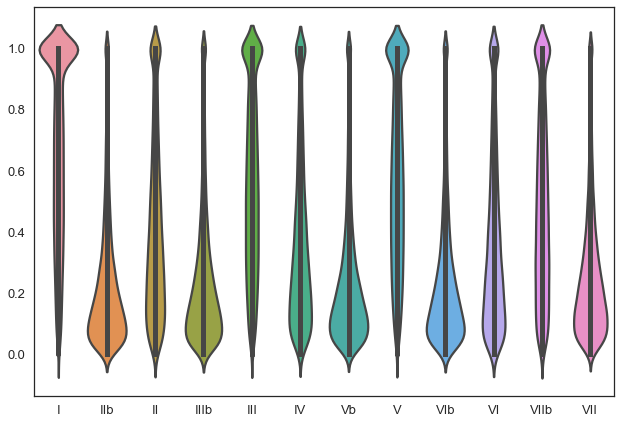

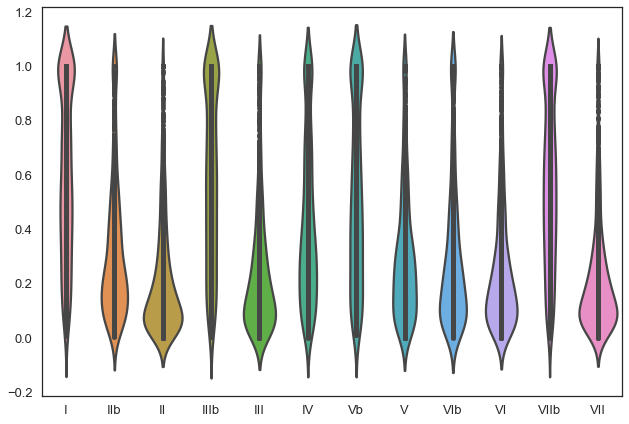

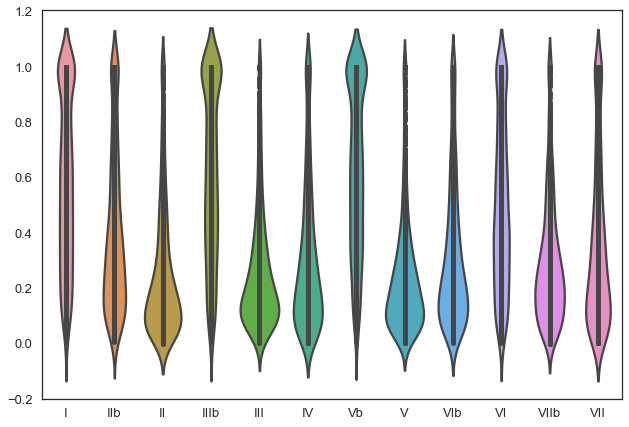

maj 75.3457738749 %
min 63.2981676846 %
dom 46.0906217071 %
hdim7 60.1265822785 %
dim 70.7240948814 %
total:  59.075334202 %
Time span:  1453.8982532
[ 59.30541982  61.07379721  57.05534918  64.14156238  65.64807427
  67.30788616  68.13255684  68.75006231  69.70451214  70.43563156
  71.06492511  71.75218797  72.96814698]
[ 58.3284594   59.61260716  55.39020907  61.20720198  61.78239431
  63.04296403  62.86584388  62.8247913   63.14272384  63.32780901
  63.4658763   63.68512083  63.97603906]


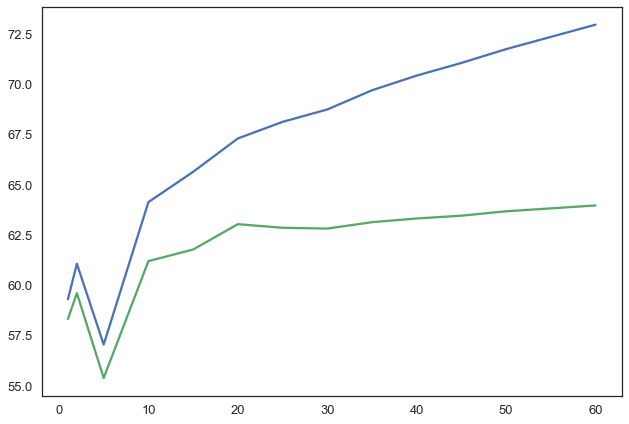

In [13]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

maxChromas = normalize(chromas, norm='max')
violinPlots12D(kinds, maxChromas)
model = fitConstModel(kinds, maxChromas, [1,1,1,1,1])
score(model, kinds, maxChromas, debug=True)
#model = fitConstModel(kinds, maxChromas, [2,6,1,1,1])
#score(model, kinds, maxChromas)
#n_components = findOptimalNComponentsByBIC(maxChromas)
#print n_components
start = time.time()
maxTrains, maxTests = trainTestSymmetricalModels(mbids, kinds, maxChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print maxTrains
print maxTests
plt.plot(symcomponents, maxTrains)
plt.plot(symcomponents, maxTests)
plt.show()

<h1> Recap from previous series.</h1>
I'm working on chord estimation for jazz audio recordings.
Primary task: identify root and chord type:
<ul>
<li> maj
<li> min
<li> dom
<li> hdim7
<li> dim
</ul>

<h2>Idea is to: </h2>
<ul>
<li> detect beats (may be: down beats,  periods by 4, 8 bars, e.g. deeper hierarchy)
<li> for each beat estimate probability of each possible chord
<li> plugin these probabilities into some model to count adjacent chord dependencies
     (and ideally: relation to segments of higher order).
</ul>     

<h2>Done before:</h2>
<ul>
<li> Have 3 datasets ("The Beatles", "Jazz": 62163 beats annotated, "Guitar": 289 beats annotated)
<li> Beat tracking: madmom
<li> NNLS Chroma: appears to be best available as shown with experiment on "The Beatles" dataset.
     Was evaluated only practically.
     Chroma = 12D vector (per value for each semintone pitch class).
<li> Preliminary chroma distribution exploration. Conclusion: after per-sample normalization, it becomes
     very "un Gaussian" (e.g. distributed  in lower dimensional spaece with boundaries, very skewed).
     For L1: it's distributed on simplex. Then, try:
     <ul>
     <li> L1 + logarithm
     <li> L1 + transform to 11D
     </ul>
</ul>

<h2> This week: </h2>
 Fit GMM model to "jazz" and "guitar" dataset. How it's evaluated:
 <ul>
 <li> All chords converted to C (only chord kind is predicted)
 <li> 5-Fold crossvalidation is used
 <li> Naive bayes classifier is applied to trained GMM to detedct chord kind.
 </ul>
 
 <h2> Results: </h2>
 <li> GMM with 60 components gives 75% test accuracy.
      (it's possible to gain almost 100% training accuracy).
      For guitar: 90% test accuracy with simple Gaussian (no mixture).
 <li> NNLS chroma features are not behaved as expected. It seems
      to compress loudness somehow, so normalization isn't necessary.
      It doens't respect perceptual model (masking) and provides counterintuitive
      results. Chroma seems to be a black box now and it's a weak point.
      It seems it could be improved.
 <li> L1 and "Un-simplex": shows better results for low number of components.
      L1 reflects perceptual/musicological approach: (proportions, as in Pitch class profiles). 
      In general, why "unsimplex" is interesting?
      <ul>
      <li> best results for small number of components in GMM
 </ul>

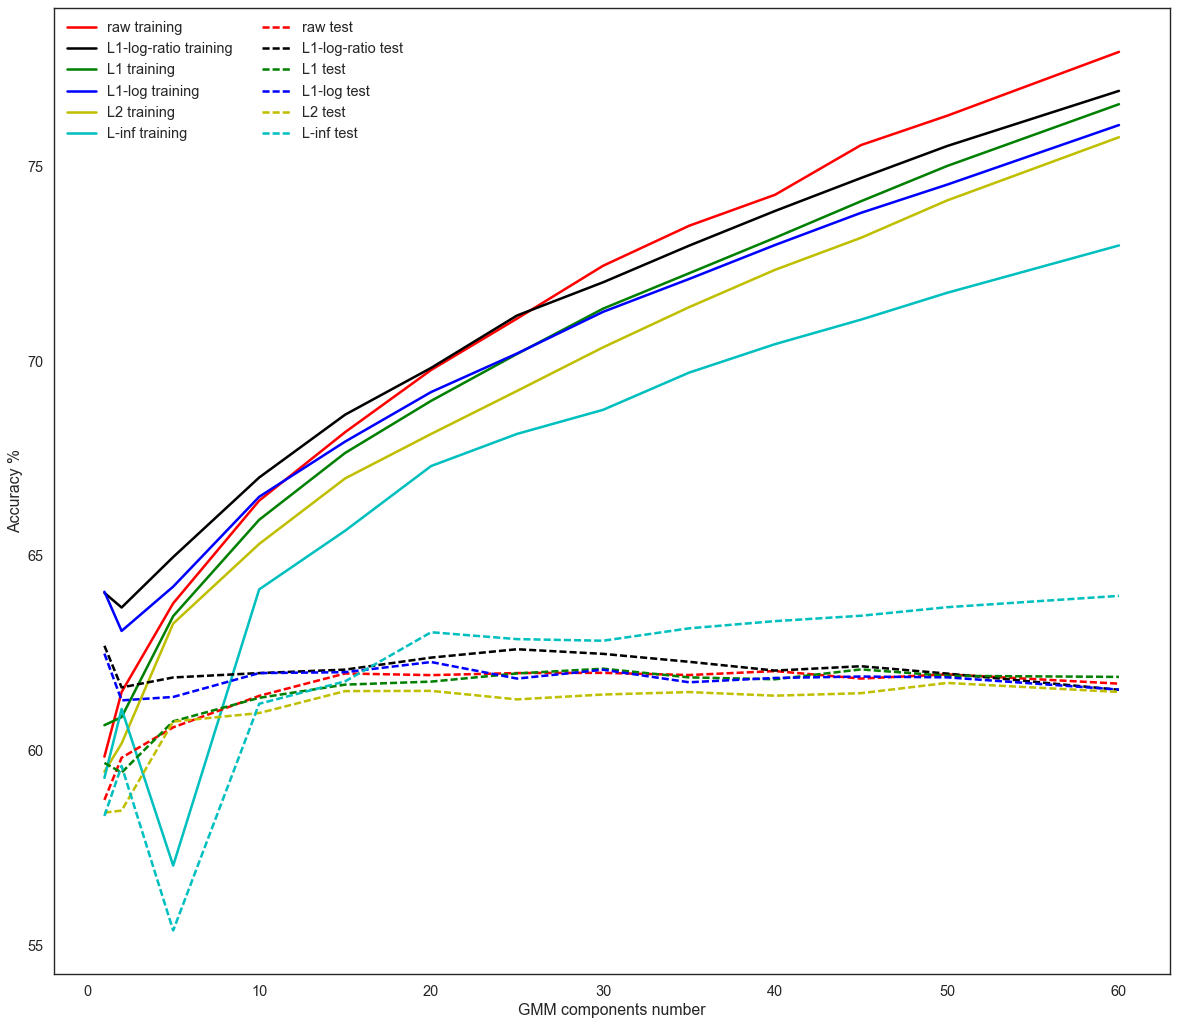

Norm / N of components,1,2,5,10,15,20,25,30,35,40,45,50,60
Raw,59.85,61.51,63.79,66.42,68.18,69.77,71.09,72.45,73.47,74.27,75.54,76.3,77.94
L1-log-ratio,64.05,63.68,64.97,67.01,68.63,69.83,71.17,72.02,72.96,73.85,74.7,75.52,76.93
L1,60.66,60.86,63.46,65.93,67.64,68.98,70.18,71.35,72.25,73.16,74.1,75.01,76.59
L1-log,64.08,63.08,64.21,66.52,67.94,69.21,70.2,71.26,72.11,72.98,73.81,74.53,76.06
L2,59.47,60.19,63.27,65.31,66.99,68.13,69.24,70.35,71.38,72.34,73.16,74.12,75.75
L-inf,59.31,61.07,57.06,64.14,65.65,67.31,68.13,68.75,69.7,70.44,71.06,71.75,72.97


Norm / N of components,1,2,5,10,15,20,25,30,35,40,45,50,60
Raw,58.74,59.82,60.6,61.41,61.98,61.94,62.0,62.0,61.94,62.05,61.85,61.96,61.72
L1-log-ratio,62.69,61.63,61.88,61.99,62.08,62.39,62.61,62.49,62.28,62.06,62.17,61.98,61.57
L1 test,59.69,59.44,60.76,61.36,61.7,61.78,61.99,62.11,61.88,61.84,62.09,61.92,61.9
L1-log,62.49,61.29,61.38,61.99,62.02,62.28,61.85,62.08,61.76,61.87,61.91,61.89,61.57
L2 test,58.41,58.47,60.75,60.97,61.53,61.54,61.32,61.44,61.51,61.41,61.48,61.74,61.51
L-inf test,58.33,59.61,55.39,61.21,61.78,63.04,62.87,62.82,63.14,63.33,63.47,63.69,63.98


In [14]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
line, = plt.plot(symcomponents, rawTrains, 'r-')
line.set_label('raw training')
line, = plt.plot(symcomponents, sxTrains, 'k-')
line.set_label('L1-log-ratio training')
line, = plt.plot(symcomponents, l1Trains, 'g-')
line.set_label('L1 training')
line, = plt.plot(symcomponents, l1logTrains, 'b-')
line.set_label('L1-log training')
line, = plt.plot(symcomponents, l2Trains, 'y-')
line.set_label('L2 training')
line, = plt.plot(symcomponents, maxTrains, 'c-')
line.set_label('L-inf training')

line, = plt.plot(symcomponents, rawTests, 'r--')
line.set_label('raw test')
line, = plt.plot(symcomponents, sxTests, 'k--')
line.set_label('L1-log-ratio test')
line, = plt.plot(symcomponents, l1Tests, 'g--')
line.set_label('L1 test')
line, = plt.plot(symcomponents, l1logTests, 'b--')
line.set_label('L1-log test')
line, = plt.plot(symcomponents, l2Tests, 'y--')
line.set_label('L2 test')
line, = plt.plot(symcomponents, maxTests, 'c--')
line.set_label('L-inf test')

plt.xlabel('GMM components number')
plt.ylabel('Accuracy %')
plt.legend(ncol=2)
plt.show()
from IPython.display import HTML, display
def line2HTML(title, data):
    return '<tr><td>' + title + '</td><td>{}</td></tr>'.format(
        '</td><td>'.join(str(round(x,2)) for x in data))

header = '<tr><th>Norm / N of components</th><th>{}</th></tr>'.format('</th><th>'.join(str(x) for x in symcomponents))
body = ''
body = body + line2HTML('Raw', rawTrains)
body = body + line2HTML('L1-log-ratio', sxTrains)
body = body + line2HTML('L1', l1Trains)
body = body + line2HTML('L1-log', l1logTrains)
body = body + line2HTML('L2', l2Trains)
body = body + line2HTML('L-inf', maxTrains)
display(HTML('<h3>Training Accuracy %</h3><table>' + header + body + '</table>'))

header = '<tr><th>Norm / N of components</th><th>{}</th></tr>'.format('</th><th>'.join(str(x) for x in symcomponents))
body = ''
body = body + line2HTML('Raw', rawTests)
body = body + line2HTML('L1-log-ratio', sxTests)
body = body + line2HTML('L1 test', l1Tests)
body = body + line2HTML('L1-log', l1logTests)
body = body + line2HTML('L2 test', l2Tests)
body = body + line2HTML('L-inf test', maxTests)
display(HTML('<h3>Test Accuracy %</h3><table>' + header + body + '</table>'))

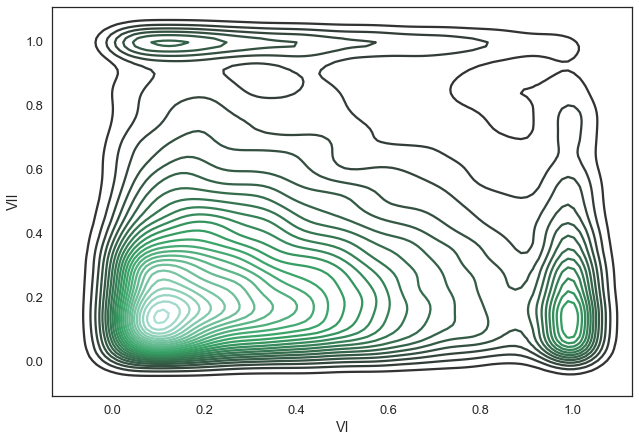

True
-262554.000512
[ 0.13742142  0.07428825  0.03608334  0.04025304  0.07707081  0.02383103
  0.01460637  0.13128992  0.21356964  0.04063981  0.12626165  0.08468472]


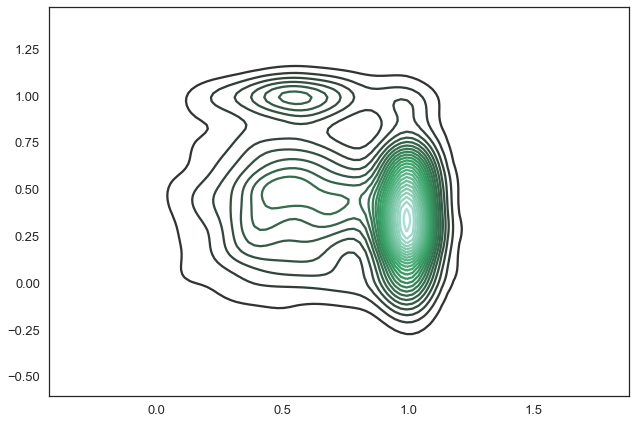

In [15]:
dMaj = pd.DataFrame(data=maxChromas[kinds =='maj'], columns=degrees)

sns.kdeplot(dMaj['VI'], dMaj['VII'], n_levels=30)
plt.show()
gm = fitMixture(dMaj.values, n_components=12)
gmMaj = gm
print gm.converged_
print gm.bic(dMaj)
print gm.weights_

samples = np.asarray(gm.sample(1000)[0])
samples[:,[0, 9]].shape
sns.kdeplot(samples[:,[0, 9]], n_levels=30)
plt.show()

In [16]:
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from scipy.misc import logsumexp
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn import linear_model, datasets
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

clf = svm.SVC(C=11, kernel = 'rbf', gamma=1.0)
kf = MBIDAwareKFold(n_splits = 5, random_state = 8)
svm_scores = cross_val_score(clf, chromas, kinds, cv=kf.split(mbids), n_jobs=-1)
score = svm_scores.mean()
print "Test error (on crossvalidation):", score * 100.0, '%'

Test error (on crossvalidation): 62.2745085933 %


In [17]:
# train error
clf = svm.SVC(C=11, kernel = 'rbf', gamma=1.0)
clf.fit(chromas, kinds)
print "Train error:", clf.score(chromas, kinds) * 100.0, '%'

Train error: 97.3585573412 %
